#### MIT License (c) 2018 by Andrew Lyasoff. 

#### Jupyter notebook written in Julia 0.6.4. It illustrates the simulation of multivariate normal samples with a given covariance matrix, and also the construction of univariate histograms. 

In [1]:
using SpecialFunctions
using StatsBase
using Plots
pyplot()

Plots.PyPlotBackend()

We write our own histogram function. It takes as an input a single 1-dimensional array of data. The number of bins in the histogram is determined automatically by using the Diaconis-Friedman rule. The function returns two arrays: the mid-points of the bins and the (unnormalized) heights of the bars.

In [2]:
function hstgram(data_sample::Array{Float64,1})
    data_sorted=sort(data_sample)
    first=data_sorted[1]
    last=data_sorted[end]
    nmb=length(data_sorted)
    IQR=percentile(data_sorted,75)-percentile(data_sorted,25)
    bin_size_loc = 2*IQR*(nmb^(-1.0/3))
    num_bins=Int(floor((last-first)/bin_size_loc))
    bin_size=(last-first)/(num_bins)
    bin_end_points=[first+(i-1)*bin_size for i=1:(num_bins+1)]
    ahist_val=[length(data_sorted[data_sorted .< u]) for u in bin_end_points]
    hist_val=[ahist_val[i+1]-ahist_val[i] for i=1:num_bins]
    mid_bins=[first-bin_size/2+i*bin_size for i=1:num_bins]
    return mid_bins, hist_val
end

hstgram (generic function with 1 method)

First, create data sampled from the standard univariate normal density.

In [3]:
val=(x->((2*π)^(-1/2)*exp(-x^2/2))).(-3.3:0.05:3.3);

Now create 10000 randomly sampled points from the standard univariate Gaussian law. Note that the random numbers generator is called in such a way that it generates the same sample each time it is called. Notice also the normalization of the heights of the bars meant to ensure that the empirical density integrates to 1 (i.e., the area of the histogram equals 1).

In [4]:
nval=randn!(MersenneTwister(215565897634598),zeros(10000));
U,V=hstgram(nval);
VV=V/(sum(V)*(U[2]-U[1]));

See the total number of bins:

In [5]:
length(VV)

62

We now plot the histogram created from the data against the standard normal density.

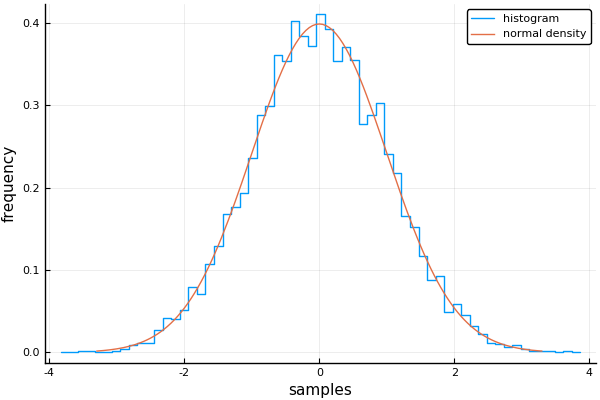

In [6]:
plot(U+(U[2]-U[1])/2,VV,line=(:steppre,1),linewidth=0.05,label="histogram")
xlabel!("samples")
ylabel!("frequency")
plot!(-3.3:0.05:3.3,val,label="normal density")

Alternatively, one can do:

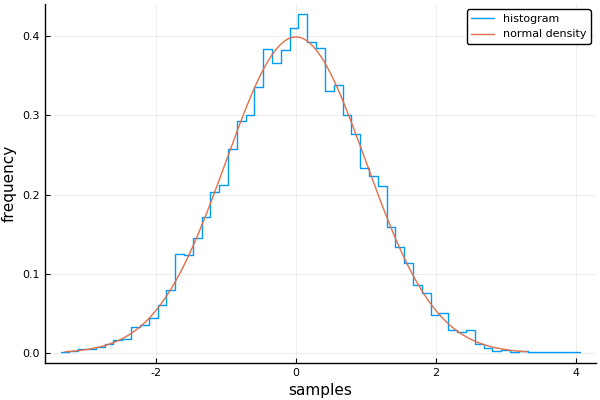

In [7]:
nval=randn(10000);
U,V=hstgram(nval);
VV=V/(sum(V)*(U[2]-U[1]));
plot(U+(U[2]-U[1])/2,VV,line=(:steppre,1),linewidth=0.05,label="histogram")
xlabel!("samples")
ylabel!("frequency")
plot!(-3.3:0.05:3.3,val,label="normal density")

Univariate Gaussian samples can be generated also by transformung an uniformly distributed sample in $[0,1[$ (this method may be less reliable).

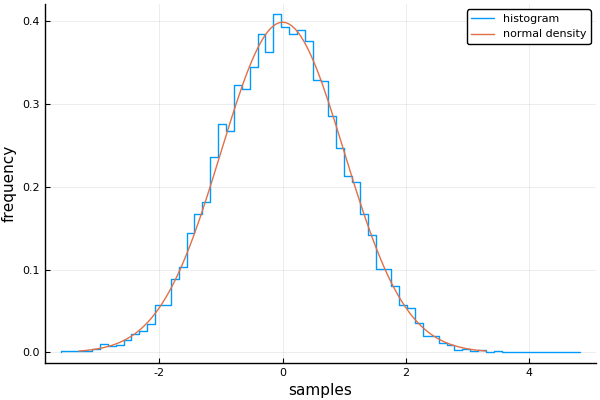

In [8]:
uval=rand(10000);
nval=(x->sqrt(2)*erfinv(2*x-1)).(uval);
U,V=hstgram(nval);
VV=V/(sum(V)*(U[2]-U[1]));
plot(U+(U[2]-U[1])/2,VV,line=(:steppre,1),linewidth=0.05,label="histogram")
xlabel!("samples")
ylabel!("frequency")
plot!(-3.3:0.05:3.3,val,label="normal density")

Now we generate 10000 samples from the bi-variate Gaussian distribution with independent and standard normal marginals.

In [9]:
nnval=randn!(MersenneTwister(12400822),zeros(10000));

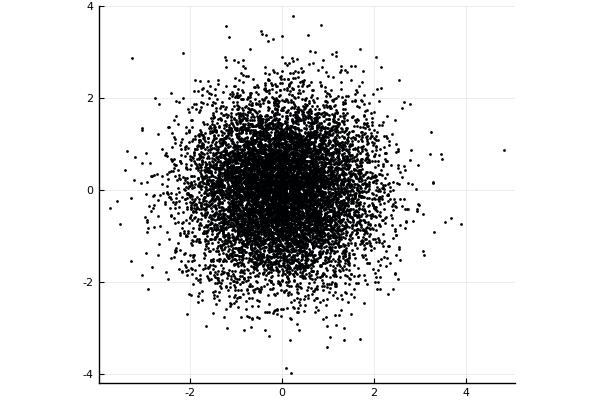

In [10]:
scatter(nval,nnval,ratio=1,markersize=1,label="")

First, create a 2x2 matrix that is positive definite and symmetric (a candidate covariance matrix). Check if it is indeed positive definite by computing the eigenvalues.

In [11]:
A=rand(2,2);
Cov=A'A;
CovEig=eigfact(Cov);
CovEig[:values]

2-element Array{Float64,1}:
 0.0276093
 1.89036  

Now generate the "square-root" of the covariance matrix.

In [12]:
MM=CovEig[:vectors]*diagm(CovEig[:values].^(1/2));

In [13]:
MM*MM'-Cov

2×2 Array{Float64,2}:
 2.22045e-16  1.11022e-16
 1.11022e-16  0.0        

Transform the randomly generated standard bi-variate sample through the "square root" of the covariance matrix.

In [14]:
t_data=[MM*[nval[i],nnval[i]] for i=1:length(nval)];
NN=hcat(nval,nnval)';
data_2_dim=MM*NN;

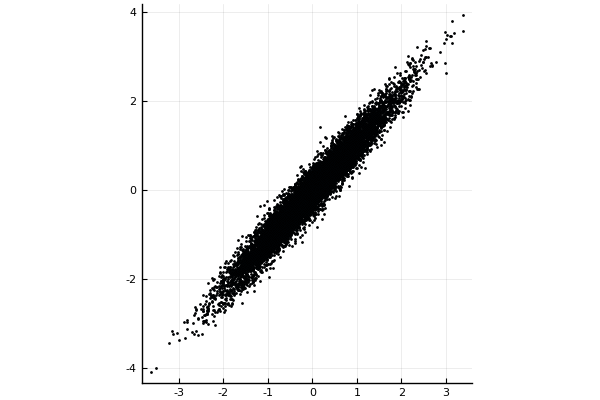

In [15]:
scatter(data_2_dim[1,:],data_2_dim[2,:],ratio=1,markersize=1,label="")

Another way to construct a "square-root" from the covariance matrix is to use Cholesky's factorization.

In [16]:
CovChol=cholfact(Cov);
MM=CovChol[:L];
MM*MM'-Cov

2×2 Array{Float64,2}:
 0.0  0.0
 0.0  0.0

In [17]:
t_data=[MM*[nval[i],nnval[i]] for i=1:length(nval)];
NN=hcat(nval,nnval)';
data_2_dim=MM*NN;

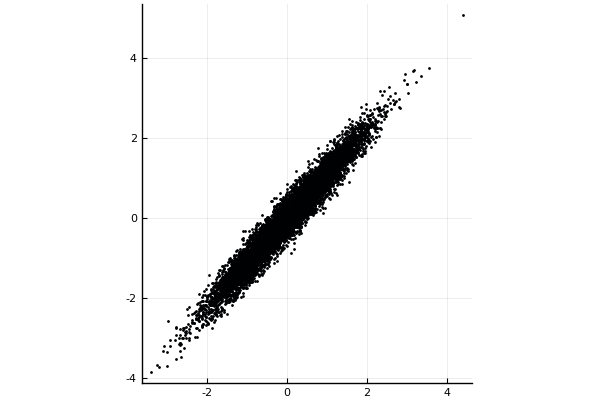

In [18]:
scatter(data_2_dim[1,:],data_2_dim[2,:],ratio=1,markersize=1,label="")